In [1]:
import os
import re
from itertools import compress

import torch

import torchvision
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.transforms import v2 as T

import utils
from engine import train_one_epoch, evaluate

import matplotlib.pyplot as plt

In [2]:
import zipfile

with zipfile.ZipFile("Dataset_BUSI_with_GT.zip", 'r') as zip_ref:
    zip_ref.extractall("")

In [3]:
class BreastCancerDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = []
        self.masks = []

        subsets = ["benign", "malignant"]

        for subset in subsets:
            for file in os.listdir(os.path.join(root, subset)):
                if re.search(pattern=".*mask.*", string=file) == None:
                    self.imgs.append(os.path.join(subset, file))
                if re.search(pattern=".*mask\.png", string=file) != None:
                    self.masks.append(os.path.join(subset, file))

        self.imgs = sorted(self.imgs)
        self.masks = sorted(self.masks)

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, self.imgs[idx])
        mask_path = os.path.join(self.root, self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # label as normal, benign, malignant
        if re.search("^n.*", self.imgs[idx]) != None:
            labels = torch.tensor((0,), dtype=torch.int64)

        if re.search("^b.*", self.imgs[idx]) != None:
            labels = torch.tensor((1,), dtype=torch.int64)

        if re.search("^m.*", self.imgs[idx]) != None:
            labels = torch.tensor((2,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(
            boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [4]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [6]:
# Apply transforms to image before training
def get_transform(train):
    transforms = []
    if train:
      transforms.append(T.RandomHorizontalFlip(0.5))

    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [7]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# classes are normal, benign, and malignant
num_classes = 3

# use our dataset and defined transformations
dataset = BreastCancerDataset("Dataset_BUSI_with_GT", get_transform(train=True))
dataset_test = BreastCancerDataset("Dataset_BUSI_with_GT", get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# set number of training epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:02<00:00, 81.8MB/s]
/content/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [  0/299]  eta: 0:15:30  lr: 0.000022  loss: 3.4458 (3.4458)  loss_classifier: 1.4485 (1.4485)  loss_box_reg: 0.1099 (0.1099)  loss_mask: 1.8686 (1.8686)  loss_objectness: 0.0142 (0.0142)  loss_rpn_box_reg: 0.0047 (0.0047)  time: 3.1127  data: 0.0541  max mem: 1938
Epoch: [0]  [ 10/299]  eta: 0:03:38  lr: 0.000189  loss: 2.6436 (2.6515)  loss_classifier: 1.1242 (1.0147)  loss_box_reg: 0.1186 (0.1295)  loss_mask: 1.6068 (1.4734)  loss_objectness: 0.0142 (0.0277)  loss_rpn_box_reg: 0.0050 (0.0061)  time: 0.7569  data: 0.0351  max mem: 2767
Epoch: [0]  [ 20/299]  eta: 0:02:54  lr: 0.000357  loss: 1.3586 (1.9033)  loss_classifier: 0.2681 (0.6101)  loss_box_reg: 0.1107 (0.1230)  loss_mask: 0.9228 (1.1427)  loss_objectness: 0.0133 (0.0222)  loss_rpn_box_reg: 0.0050 (0.0054)  time: 0.5006  data: 0.0290  max mem: 2767
Epoch: [0]  [ 30/299]  eta: 0:02:38  lr: 0.000525  loss: 0.9038 (1.5266)  loss_classifier: 0.1327 (0.4507)  loss_box_reg: 0.0906 (0.1109)  loss_mask: 0.6269 (0.9355) 

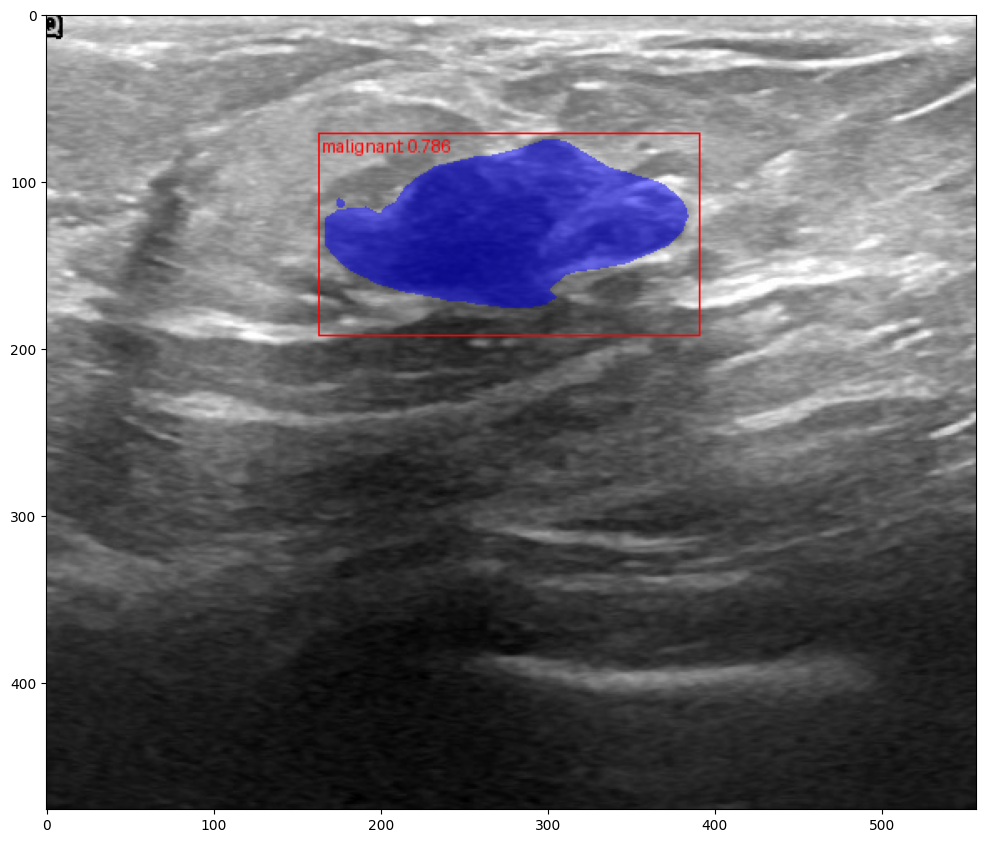

In [8]:
image = read_image("Dataset_BUSI_with_GT/malignant/malignant (100).png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)

    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)

    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]

min_conf = 0.5
conf_index = (pred["scores"] >= min_conf).tolist()


try:
  output_scores = list(compress(pred["scores"], conf_index))
  output_boxes = pred["boxes"][torch.tensor(conf_index)]
  output_labels = list(compress(pred["labels"], conf_index))
  output_masks = pred["masks"][torch.tensor(conf_index)]


  print_labels=["benign" if label==1 else "malignant" for label in output_labels]
  pred_labels = [f"{label}: {score:.3f}" for label, score in zip(print_labels, output_scores)]

  pred_boxes = output_boxes.long()

  output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

  masks = (output_masks > 0.7).squeeze(1)
  output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

except:
  # display original image if no predictions meet min_conf
  output_image = image

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

In [ ]:
output_scores

[tensor(0.7278, device='cuda:0'), tensor(0.6543, device='cuda:0')]

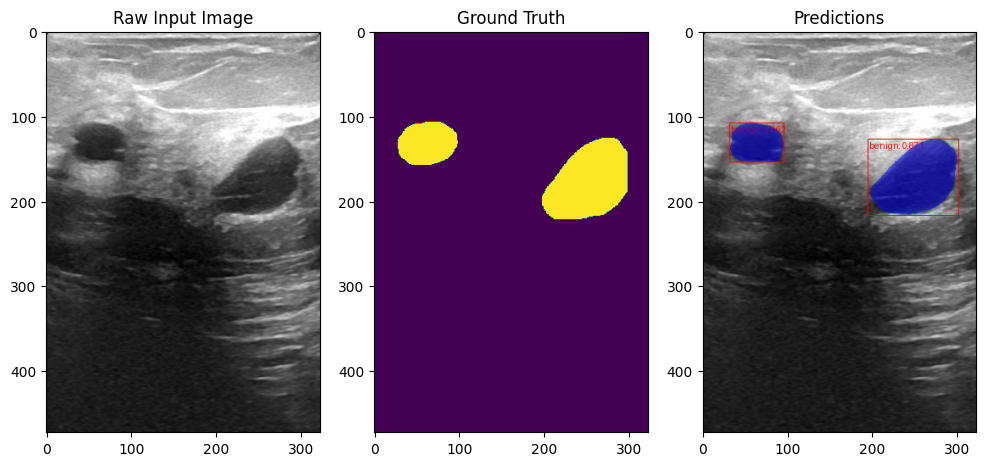

In [9]:
image = read_image("Dataset_BUSI_with_GT/benign/benign (100).png")
mask = read_image("Dataset_BUSI_with_GT/benign/benign (100)_mask.png")+read_image("Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)

    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)

    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]

min_conf = 0.5
conf_index = (pred["scores"] >= min_conf).tolist()


try:
  output_scores = list(compress(pred["scores"], conf_index))
  output_boxes = pred["boxes"][torch.tensor(conf_index)]
  output_labels = list(compress(pred["labels"], conf_index))
  output_masks = pred["masks"][torch.tensor(conf_index)]


  print_labels=["benign" if label==1 else "malignant" for label in output_labels]
  pred_labels = [f"{label}: {score:.3f}" for label, score in zip(print_labels, output_scores)]

  pred_boxes = output_boxes.long()

  output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

  masks = (output_masks > 0.7).squeeze(1)
  output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

except:
  # display original image if no predictions meet min_conf
  output_image = image


fig, ax = plt.subplots(1, 3, figsize=(12, 12))


ax[0].imshow(image.permute(1, 2, 0))
ax[0].set_title("Raw Input Image")

ax[1].imshow(mask.permute(1, 2, 0))
ax[1].set_title("Ground Truth")

ax[2].imshow(output_image.permute(1, 2, 0))
ax[2].set_title("Predictions")

plt.show()


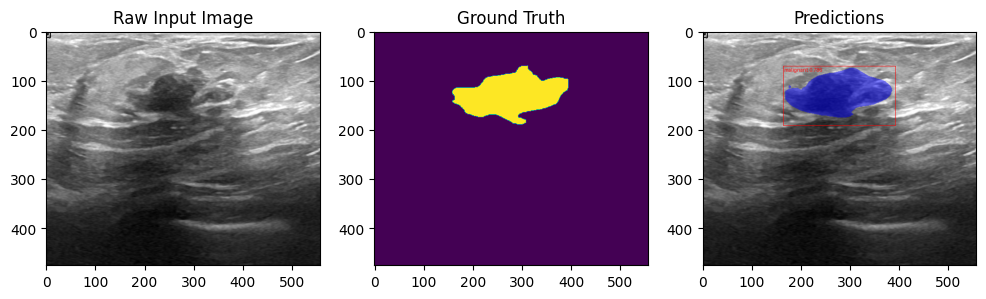

In [10]:
image = read_image("Dataset_BUSI_with_GT/malignant/malignant (100).png")
mask = read_image("Dataset_BUSI_with_GT/malignant/malignant (100)_mask.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)

    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)

    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]

min_conf = 0.5
conf_index = (pred["scores"] >= min_conf).tolist()


try:
  output_scores = list(compress(pred["scores"], conf_index))
  output_boxes = pred["boxes"][torch.tensor(conf_index)]
  output_labels = list(compress(pred["labels"], conf_index))
  output_masks = pred["masks"][torch.tensor(conf_index)]


  print_labels=["benign" if label==1 else "malignant" for label in output_labels]
  pred_labels = [f"{label}: {score:.3f}" for label, score in zip(print_labels, output_scores)]

  pred_boxes = output_boxes.long()

  output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

  masks = (output_masks > 0.7).squeeze(1)
  output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

except:
  # display original image if no predictions meet min_conf
  output_image = image


fig, ax = plt.subplots(1, 3, figsize=(12, 12))


ax[0].imshow(image.permute(1, 2, 0))
ax[0].set_title("Raw Input Image")

ax[1].imshow(mask.permute(1, 2, 0))
ax[1].set_title("Ground Truth")

ax[2].imshow(output_image.permute(1, 2, 0))
ax[2].set_title("Predictions")

plt.show()


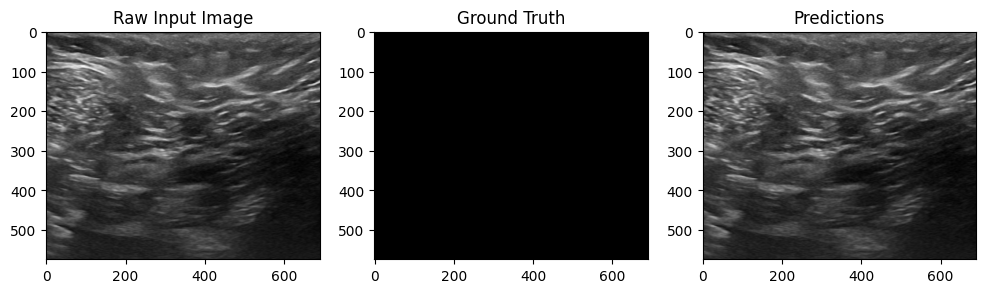

In [11]:
image = read_image("Dataset_BUSI_with_GT/normal/normal (100).png")
mask = read_image("Dataset_BUSI_with_GT/normal/normal (100)_mask.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)

    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)

    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]

min_conf = 0.5
conf_index = (pred["scores"] >= min_conf).tolist()


try:
  output_scores = list(compress(pred["scores"], conf_index))
  output_boxes = pred["boxes"][torch.tensor(conf_index)]
  output_labels = list(compress(pred["labels"], conf_index))
  output_masks = pred["masks"][torch.tensor(conf_index)]


  print_labels=["benign" if label==1 else "malignant" for label in output_labels]
  pred_labels = [f"{label}: {score:.3f}" for label, score in zip(print_labels, output_scores)]

  pred_boxes = output_boxes.long()

  output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

  masks = (output_masks > 0.7).squeeze(1)
  output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

except:
  # display original image if no predictions meet min_conf
  output_image = image


fig, ax = plt.subplots(1, 3, figsize=(12, 12))


ax[0].imshow(image.permute(1, 2, 0))
ax[0].set_title("Raw Input Image")

ax[1].imshow(mask.permute(1, 2, 0))
ax[1].set_title("Ground Truth")

ax[2].imshow(output_image.permute(1, 2, 0))
ax[2].set_title("Predictions")

plt.show()